In [ ]:
!pip install -q transformers ftfy regex
!pip install -q kaggle
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 40.0 MB/s eta 0:00:00


In [ ]:
import os
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from torch.optim import AdamW
from PIL import Image
import faiss
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
#if not os.path.exists('/root/.kaggle/kaggle.json'):
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c shopee-product-matching
!unzip -q shopee-product-matching.zip -d shopee_dataset

100% 1.68G/1.68G [00:22<00:00, 42.9MB/s]
100% 1.68G/1.68G [00:22<00:00, 81.0MB/s]


In [ ]:
if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()
    for fn in uploaded.keys():
        os.makedirs('/root/.kaggle', exist_ok=True)
        destination_path = os.path.join('/root/.kaggle', 'kaggle.json')
        os.rename(fn, destination_path)
        os.chmod(destination_path, 0o600)

**Reasoning**:
The file has been uploaded and the Python code for moving and permissioning the file has been executed without error messages in the output. I should now verify if the `kaggle.json` file exists in the correct location with the correct permissions before proceeding.



In [ ]:
!ls -l /root/.kaggle/kaggle.json

-rw------- 1 root root 69 Jul 29 10:57 /root/.kaggle/kaggle.json


## Load the data

### Subtask:
Load the `train.csv` file into a pandas DataFrame.


**Reasoning**:
Load the train.csv file into a pandas DataFrame.



In [ ]:
df = pd.read_csv('shopee_dataset/train.csv')

In [ ]:
df['image_path'] = df['image'].apply(lambda x: os.path.join('shopee_dataset', 'train_images', x))


## Summary:

### Data Analysis Key Findings

*   The initial attempt to use shell commands (`!mv`, `!chmod`) for file operations failed due to incorrect variable expansion and resulted in errors like `mv: cannot stat '$fn': No such file or directory` and `chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory`.
*   Switching from shell commands to Python's `os` module (`os.makedirs`, `os.rename`, `os.chmod`) successfully created the necessary directory, moved/renamed the `kaggle.json` file, and set the correct permissions (`-rw-------`) without errors.
*   The `kaggle competitions download` command and the `unzip` command successfully downloaded and extracted the `shopee-product-matching` dataset, confirming the corrected authentication setup.
*   The `train.csv` file was successfully loaded into a pandas DataFrame using `pd.read_csv()`.

### Insights or Next Steps

*   Prioritize using Python's built-in modules like `os` for file system operations within Python environments to avoid potential issues with shell command syntax and variable handling.
*   Proceed with the analysis of the loaded `train.csv` DataFrame to understand the dataset structure and content for the downstream tasks.


In [ ]:
df_sample = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import random

class ShopeeDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df.reset_index(drop=True)
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        while True:
            row = self.df.iloc[idx]
            text = row['title']

            try:
                image = Image.open(row['image_path']).convert("RGB")
                image = image.resize((224, 224))  # Ensure consistent input size
                inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.squeeze(0) for k, v in inputs.items()}
                return inputs
            except Exception as e:
                print(f"Error loading image {row['image_path']}: {e}")
                idx = random.randint(0, len(self.df) - 1)


In [ ]:
# @title 3. Model Fine-Tuning with Contrastive Loss

# Load pre-trained CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

def contrastive_loss(image_features, text_features, temperature=0.07):
    image_features = F.normalize(image_features, dim=1)
    text_features = F.normalize(text_features, dim=1)

    logits = torch.matmul(text_features, image_features.T) / temperature
    labels = torch.arange(len(logits)).to(logits.device)

    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.T, labels)
    return (loss_i + loss_t) / 2


In [ ]:
# Create Dataset and DataLoader
# We will create positive pairs based on the label_group
# For simplicity, we'll use the title of a matching product as the positive text pair for an image
df_train = df_sample.copy()
positive_pairs = []
for _, group in df_train.groupby('label_group'):
    if len(group) > 1:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                positive_pairs.append({'image_path': group.iloc[i]['image_path'], 'title': group.iloc[j]['title']})

df_positive = pd.DataFrame(positive_pairs)

train_dataset = ShopeeDataset(df_positive, processor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
def custom_collate_fn(batch):
    input_ids = [item["input_ids"].squeeze(0) for item in batch]
    attention_mask = [item["attention_mask"].squeeze(0) for item in batch]
    pixel_values = [item["pixel_values"].squeeze(0) for item in batch]

    batch_inputs = processor.tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_mask},
        return_tensors="pt",
        padding=True
    )

    pixel_values = torch.stack(pixel_values)

    return {
        "input_ids": batch_inputs["input_ids"],
        "attention_mask": batch_inputs["attention_mask"],
        "pixel_values": pixel_values
    }


In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=custom_collate_fn
)


In [ ]:
from transformers import get_cosine_schedule_with_warmup

num_epochs = 5  # ✅ Add this line

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * len(train_dataloader) * num_epochs),
    num_training_steps=len(train_dataloader) * num_epochs,
)

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch in tqdm(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds

        loss = contrastive_loss(image_features, text_features)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    print(f"Avg Loss: {total_loss / len(train_dataloader):.4f}")


Epoch 1/5


  0%|          | 0/879 [00:00<?, ?it/s]

You're using a CLIPTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Avg Loss: 0.3047
Epoch 2/5


  0%|          | 0/879 [00:00<?, ?it/s]

Avg Loss: 0.0658
Epoch 3/5


  0%|          | 0/879 [00:00<?, ?it/s]

Avg Loss: 0.0371
Epoch 4/5


  0%|          | 0/879 [00:00<?, ?it/s]

Avg Loss: 0.0299
Epoch 5/5


  0%|          | 0/879 [00:00<?, ?it/s]

Avg Loss: 0.0271


In [ ]:
# Save the fine-tuned model
model.save_pretrained("shopee_clip_model")
processor.save_pretrained("shopee_clip_model")

[]

In [ ]:
# @title 4. Building the Search Index with FAISS

# Generate embeddings for the entire sample dataset
all_image_embeddings = []
model.eval()

with torch.no_grad():
    for image_path in tqdm(df_sample['image_path']):
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        all_image_embeddings.append(image_features.cpu().numpy())

all_image_embeddings = np.vstack(all_image_embeddings)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:

# Normalize the image embeddings
faiss.normalize_L2(all_image_embeddings)

# Use cosine similarity via IndexFlatIP
index = faiss.IndexFlatIP(all_image_embeddings.shape[1])
index.add(all_image_embeddings)
faiss.write_index(index, "shopee_image.index")
df_sample.to_csv("shopee_image_mapping.csv", index=False)

In [ ]:
# @title 5. Cross-Modal Search in Action

# Load the saved model, index, and mapping
model = CLIPModel.from_pretrained("shopee_clip_model").to(device)
processor = CLIPProcessor.from_pretrained("shopee_clip_model")
index = faiss.read_index("shopee_image.index")
df_map = pd.read_csv("shopee_image_mapping.csv")

def text_to_image_search(text_query, top_k=5):
    model.eval()
    with torch.no_grad():
        inputs = processor(text=[text_query], return_tensors="pt").to(device)
        text_features = model.get_text_features(**inputs)
        query_embedding = text_features.cpu().numpy()
        faiss.normalize_L2(query_embedding)

    distances, indices = index.search(query_embedding, top_k)

    print(f"Top {top_k} results for: '{text_query}'")
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices[0]):
        plt.subplot(1, top_k, i + 1)
        image = Image.open(df_map.iloc[idx]['image_path'])
        plt.imshow(image)
        plt.title(f"Dist: {distances[0][i]:.2f}\n{df_map.iloc[idx]['title'][:30]}...")
        plt.axis('off')
    plt.show()


In [ ]:
def image_to_image_search(image_path, top_k=5):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert("RGB").resize((224, 224))
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        query_embedding = image_features.cpu().numpy()
        faiss.normalize_L2(query_embedding)

    distances, indices = index.search(query_embedding, top_k + 1)

    print(f"Top {top_k} similar items for the query image:")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(Image.open(image_path))
    plt.title("Query Image")
    plt.axis('off')

    shown = 0
    for i, idx in enumerate(indices[0]):
        if df_map.iloc[idx]['image_path'] == image_path:
            continue
        shown += 1
        plt.subplot(1, top_k + 1, shown + 1)
        result_image = Image.open(df_map.iloc[idx]['image_path'])
        plt.imshow(result_image)
        plt.title(f"Dist: {distances[0][i]:.2f}\n{df_map.iloc[idx]['title'][:30]}...")
        plt.axis('off')
        if shown == top_k:
            break
    plt.show()


--- Text-to-Image Search ---
Top 5 results for: 'black and white striped t-shirt'


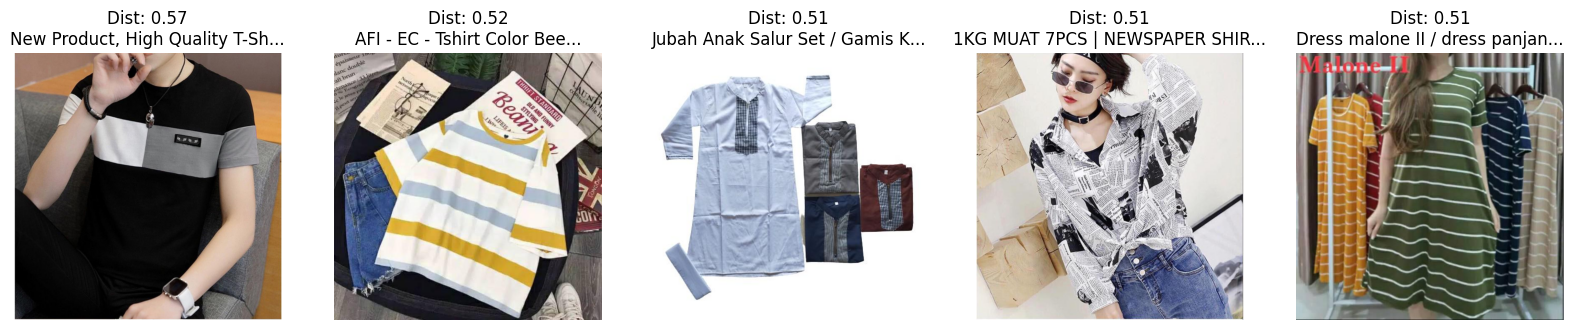

Top 5 results for: 'women's floral dress'


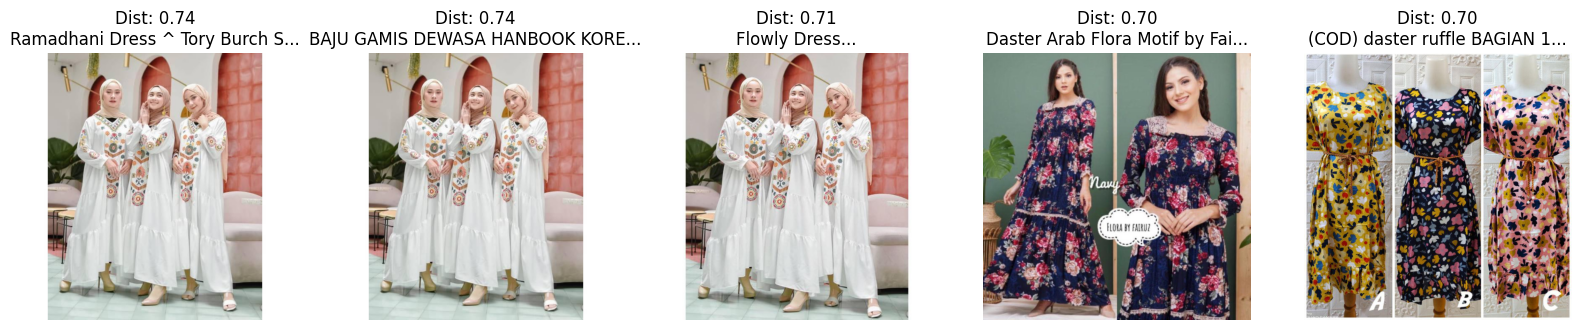


--- Image-to-Image Search ---


In [ ]:
# --- Interactive Search Examples ---
print("--- Text-to-Image Search ---")
text_to_image_search("black and white striped t-shirt")
text_to_image_search("women's floral dress")


print("\n--- Image-to-Image Search ---")


Top 5 similar items for the query image:


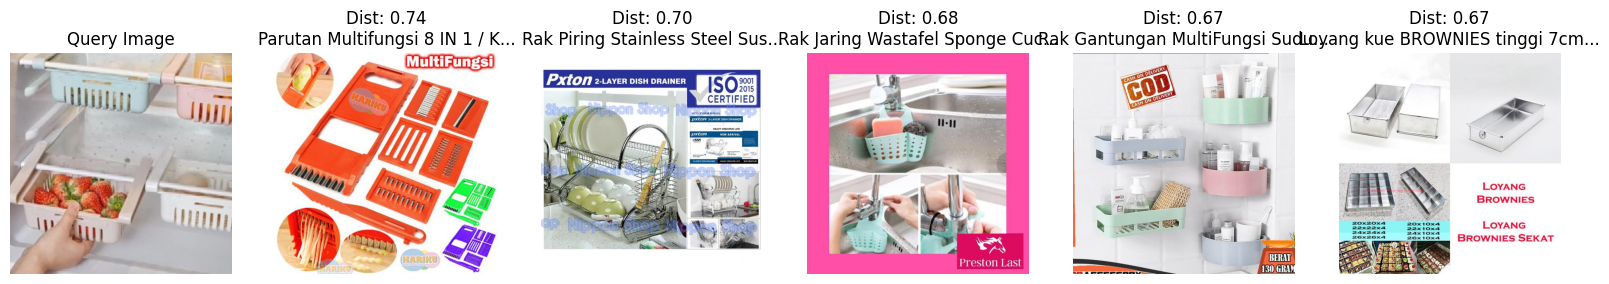

In [ ]:
# Choose a random image from our dataset to query
query_image_path = df_map.sample(1).iloc[0]['image_path']
image_to_image_search(query_image_path)

In [ ]:
import os

# Make project folder and model subfolder
os.makedirs("fashion_search_app/shopee_clip_model", exist_ok=True)


In [ ]:
# Save the fine-tuned CLIP model and processor
model.save_pretrained("fashion_search_app/shopee_clip_model")
processor.save_pretrained("fashion_search_app/shopee_clip_model")


[]

In [ ]:
# Save index and mapping inside the folder
faiss.write_index(index, "fashion_search_app/shopee_image.index")
df_map.to_csv("fashion_search_app/shopee_image_mapping.csv", index=False)


In [ ]:
with open("fashion_search_app/app.py", "w") as f:
    f.write("""
import streamlit as st
import faiss
import pandas as pd
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np

# --- Configuration ---
MODEL_PATH = "shopee_clip_model"
FAISS_INDEX_PATH = "shopee_image.index"
MAPPING_CSV_PATH = "shopee_image_mapping.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Caching to Speed Up App ---
@st.cache_resource
def load_model_and_processor():
    model = CLIPModel.from_pretrained(MODEL_PATH).to(DEVICE)
    processor = CLIPProcessor.from_pretrained(MODEL_PATH)
    return model, processor

@st.cache_data
def load_index_and_mapping():
    index = faiss.read_index(FAISS_INDEX_PATH)
    df_map = pd.read_csv(MAPPING_CSV_PATH)
    return index, df_map

# --- Core Search Functions ---
def search_by_text(text_query, model, processor, index, df_map, top_k=5):
    model.eval()
    with torch.no_grad():
        inputs = processor(text=[text_query], return_tensors="pt").to(DEVICE)
        text_features = model.get_text_features(**inputs)
        query_embedding = text_features.cpu().numpy()

    distances, indices = index.search(query_embedding, top_k)

    results = []
    for i, idx in enumerate(indices[0]):
        row = df_map.iloc[idx]
        results.append({
            'image_path': row['image_path'],
            'title': row['title'],
            'distance': distances[0][i]
        })
    return results

def search_by_image(image, model, processor, index, df_map, top_k=5):
    model.eval()
    with torch.no_grad():
        image = image.convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        image_features = model.get_image_features(**inputs)
        query_embedding = image_features.cpu().numpy()

    distances, indices = index.search(query_embedding, top_k)

    results = []
    for i in range(top_k):
        idx = indices[0][i]
        row = df_map.iloc[idx]
        results.append({
            'image_path': row['image_path'],
            'title': row['title'],
            'distance': distances[0][i]
        })
    return results

# --- Streamlit UI ---
st.set_page_config(page_title="Cross-Modal Fashion Search", layout="wide")
model, processor = load_model_and_processor()
index, df_map = load_index_and_mapping()

st.title("👕👗 Cross-Modal Fashion Search Engine 👠👟")
st.write("Find fashion items using a text description or a sample image.")

st.sidebar.title("Search Options")
search_type = st.sidebar.radio("Choose your search type:", ("Text-to-Image", "Image-to-Image"))

if search_type == "Text-to-Image":
    st.header("Search by Text")
    text_query = st.text_input("Enter a description (e.g., 'blue floral dress', 'men's leather jacket')", "black and white striped t-shirt")
    if st.button("Search by Text"):
        if text_query:
            with st.spinner("Finding similar items..."):
                results = search_by_text(text_query, model, processor, index, df_map)
                st.subheader(f"Top results for: '{text_query}'")
                cols = st.columns(len(results))
                for i, res in enumerate(results):
                    with cols[i]:
                        st.image(res['image_path'], caption=f"Dist: {res['distance']:.2f}", use_container_width=True)
                        st.write(res['title'])
        else:
            st.warning("Please enter a search query.")

elif search_type == "Image-to-Image":
    st.header("Search by Image")
    uploaded_file = st.file_uploader("Upload an image of a fashion item", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        query_image = Image.open(uploaded_file)
        st.image(query_image, caption="Your Query Image", width=250)
        if st.button("Find Similar Items"):
            with st.spinner("Searching..."):
                results = search_by_image(query_image, model, processor, index, df_map)
                st.subheader("Top similar items found:")
                cols = st.columns(len(results))
                for i, res in enumerate(results):
                    with cols[i]:
                        st.image(res['image_path'], caption=f"Dist: {res['distance']:.2f}", use_container_width=True)
                        st.write(res['title'])
""")


In [ ]:
# Zip the fashion_search_app folder
!zip -r fashion_search_app.zip fashion_search_app


  adding: fashion_search_app/ (stored 0%)
  adding: fashion_search_app/shopee_clip_model/ (stored 0%)
  adding: fashion_search_app/shopee_clip_model/config.json (deflated 66%)
  adding: fashion_search_app/shopee_clip_model/tokenizer.json (deflated 83%)
  adding: fashion_search_app/shopee_clip_model/vocab.json (deflated 62%)
  adding: fashion_search_app/shopee_clip_model/tokenizer_config.json (deflated 63%)
  adding: fashion_search_app/shopee_clip_model/model.safetensors (deflated 7%)
  adding: fashion_search_app/shopee_clip_model/special_tokens_map.json (deflated 78%)
  adding: fashion_search_app/shopee_clip_model/preprocessor_config.json (deflated 50%)
  adding: fashion_search_app/shopee_clip_model/merges.txt (deflated 60%)
  adding: fashion_search_app/shopee_image_mapping.csv (deflated 58%)
  adding: fashion_search_app/shopee_image.index (deflated 7%)
  adding: fashion_search_app/app.py (deflated 67%)


In [ ]:
from google.colab import files
files.download("fashion_search_app.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>